In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

import process


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
X_train, X_val, X_test, Y_train, Y_val, Y_test, mask = process.load_data()

Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


In [4]:
X_train = X_train.to(device)
X_val = X_val.to(device)
X_test = X_test.to(device)
Y_train = Y_train.to(device)
Y_val = Y_val.to(device)
Y_test = Y_test.to(device)

In [5]:
class AKModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        d_in, d_out= X_train.shape[-1], Y_train.shape[-1]
        self.linear = torch.nn.Linear(d_in, d_out)
        self.deep1 = torch.nn.Sequential(torch.nn.Linear(d_in, 1000),
                                         torch.nn.Sigmoid(),
                                         torch.nn.Linear(1000, 1000),
                                         torch.nn.Sigmoid(),
                                         torch.nn.Linear(1000, 1000),
                                         torch.nn.Sigmoid(),
                                         torch.nn.Linear(1000, d_out))
        self.deep1 = torch.nn.Sequential(torch.nn.Linear(d_in, 1000),
                                         torch.nn.Linear(1000, d_out))
        
        self.deep2 = torch.nn.Sequential(torch.nn.Linear(d_in, 1000),
                                         torch.nn.Sigmoid(),
                                         torch.nn.Linear(1000, d_out))
        
    def forward(self, X):
#         Y = self.linear(X) + self.deep1(X)
        Y = self.deep1(X) + self.deep2(X)
        return Y

In [6]:
model = AKModel().to(device)

In [7]:
# model = torch.nn.Sequential(torch.nn.Linear(delRstim.shape[-1], mask.sum())).to(device)

# opt = torch.optim.SGD(model.parameters(), lr=3e1, weight_decay=1e-4)
# opt = torch.optim.SGD(model.parameters(), lr=6e1)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

bs = 4000
all_idxs = range(len(X_train))

for epoch_idx in tqdm(range(1000)[:1000]):
    all_batch_idxs = [all_idxs[i: i+bs] for i in range(0, len(all_idxs), bs)]
    for batch_idxs in (all_batch_idxs):
        X_batch = X_train[batch_idxs]
        Y_batch = Y_train[batch_idxs]
        Y_batch_pred = model(X_batch)
    
        loss = (Y_batch-Y_batch_pred).pow(2).mean()
        
        
        Y_test_pred = model(X_test)
        loss_test = (Y_test-Y_test_pred).pow(2).mean()
        
        opt.zero_grad()
        loss.backward()
#         print('grad')
#         print(list(model.parameters())[0].grad.max())
        opt.step()
        loss = loss.detach()
        
    mse_train, corr_train = process.calc_stats(Y_batch.detach(), model(X_batch).detach())
    mse_test, corr_test = process.calc_stats(Y_test.detach(), model(X_test).detach())
    if epoch_idx%5==0:
        process.show_stats(Y_test, model(X_test))

MSE:  1.1722712516784668
Mean Correlation:  0.0043732766062021255
MSE:  1.0577479600906372
Mean Correlation:  0.045521628111600876
MSE:  1.0779218673706055
Mean Correlation:  0.060286231338977814
MSE:  1.0722604990005493
Mean Correlation:  0.0743066668510437
MSE:  1.0942376852035522
Mean Correlation:  0.0717579647898674
MSE:  1.1545929908752441
Mean Correlation:  0.06225591152906418
MSE:  1.2089258432388306
Mean Correlation:  0.05678602308034897



KeyboardInterrupt: 

MSE:  1.2332831621170044
Mean Correlation:  0.05668220296502113


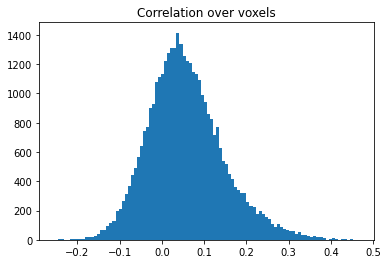

In [8]:
process.show_stats(Y_test, model(X_test), show_vox_corr_hist=True)